In [19]:
import os
import pandas as pd
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import re

from eunjeon import Mecab
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, f1_score

from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Input, Flatten, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Bidirectional
from gensim.models import Word2Vec

plt.rc('font', family='Malgun Gothic')


In [20]:
# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [21]:
data_dir = '../analysis_files/files/'
data_dir2 = '../analysis_files/word2vec/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# mecab 모델 다운로드
tokenizer = Mecab()

In [22]:
def text_clearing(text): 
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
    result = hangul.sub('', text)
    return result

In [23]:
def load_dataset(data_dir):
    df = pd.read_csv(os.path.join(data_dir, '감성대화말뭉치(최종데이터)_Validation_add.csv'), encoding='cp949')
    df = df[['사람문장1', '감정_대분류']]

    # NaN values and empty strings removal
    df.dropna(subset=['사람문장1'], inplace=True)
    df = df[df.astype(str).ne('').all(axis=1)]
    df["사람문장1"] = df["사람문장1"].apply(lambda x : text_clearing(x))
    
    # Label encoding with custom mapping for emotions
    emotion_mapping = {
        '기쁨': '긍정', 
        '당황': '부정', 
        '분노': '부정',
        '불안': '부정', 
        '상처': '부정', 
        '슬픔': '부정' 
    }
    
    df['긍/부정'] = df['감정_대분류'].map(emotion_mapping)
    df = df[['사람문장1', '긍/부정']]
    
    # Label encoding
    emotion_encoder = LabelEncoder()
    df['pos'] = emotion_encoder.fit_transform(df['긍/부정'])
    
    # Create label mapping dictionaries
    pos_mapping = dict(zip(emotion_encoder.classes_, emotion_encoder.transform(emotion_encoder.classes_)))
    
    # Data split
    train_df, test_df = train_test_split(df, test_size=0.1, random_state=seed)
    
    return train_df, test_df, pos_mapping

In [24]:
train_df, test_df, pos_mapping = load_dataset(data_dir)

# Print the label mappings
print("Emotion Label Mapping:")
for pos, encoded_label in pos_mapping.items():
    print(f"{pos}: {encoded_label}")

Emotion Label Mapping:
긍정: 0
부정: 1


In [25]:
train_df.head()

,사람문장1,긍/부정,pos
5024,일이 너무 많아서 너무 힘들어,부정,1
5714,어제 경찰서에서 연락이 왔는데 친구가 우리 계비로 사기를 쳤나 봐 어떻게 이런 일이...,부정,1
2301,나는 탁구를 정말 좋아하는데 요즘 몸이 잘 따라주지 않아서 걱정이야,부정,1
11852,요즘 왜 이렇게 질투가 나는지 모르겠어,부정,1
2012,자식이 이제 대학교를 졸업해서 나한테 큰 지출은 없을 거 같아서 뿌듯하고 기뻐,긍정,0


In [27]:
utterance_train = train_df['사람문장1'].tolist()
label_emotion_train = train_df['pos'].tolist()
utterance_test = test_df['사람문장1'].tolist()
label_emotion_test = test_df['pos'].tolist()

print('훈련용 문장의 수 :', len(utterance_train))
print('훈련용 감정레이블의 수 :', len(label_emotion_train))
print('테스트용 문장의 수 :', len(utterance_test))
print('테스트용 감정레이블의 수 :', len(label_emotion_test))

훈련용 문장의 수 : 10753
훈련용 감정레이블의 수 : 10753
테스트용 문장의 수 : 1195
테스트용 감정레이블의 수 : 1195


<Axes: xlabel='긍/부정'>

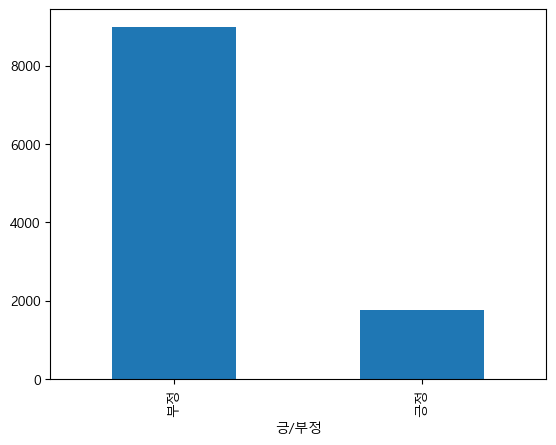

In [28]:
train_df['긍/부정'].value_counts().plot(kind = 'bar')

<Axes: xlabel='긍/부정'>

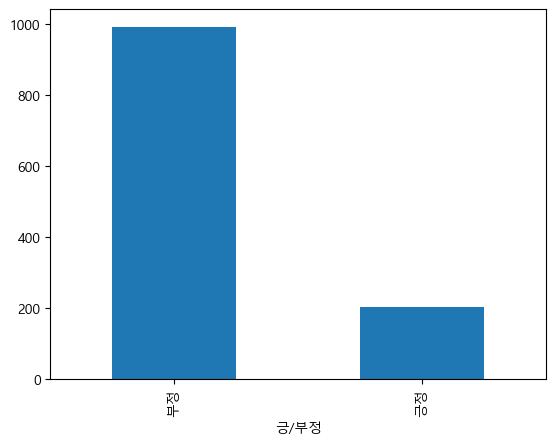

In [29]:
test_df['긍/부정'].value_counts().plot(kind = 'bar')

In [30]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['사람문장1'].tolist())
sequences_train = tokenizer.texts_to_sequences(train_df['사람문장1'].tolist())
sequences_test = tokenizer.texts_to_sequences(test_df['사람문장1'].tolist())
sequences_train[:5] # 상위 5개 샘플 출력

[[62, 1, 225, 1, 48],
 [83, 3763, 240, 308, 8, 17, 8004, 783, 8005, 24, 55, 245, 62, 121],
 [14, 8006, 11, 2455, 9, 116, 20, 5017, 94, 63],
 [9, 59, 112, 531, 8007, 76],
 [635, 41, 5018, 5019, 67, 157, 5020, 428, 31, 35, 3764, 71]]

In [31]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print('단어 집합(Vocabulary)의 크기 :',vocab_size)

단어 집합(Vocabulary)의 크기 : 20718


문장의 최대 길이 : 27
문장의 평균 길이 : 9.497163582256114


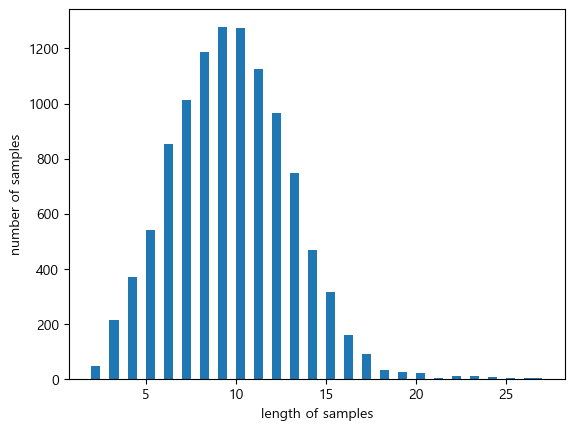

In [32]:
print('문장의 최대 길이 :',max(len(l) for l in sequences_train))
print('문장의 평균 길이 :',sum(map(len, sequences_train))/len(sequences_train))
plt.hist([len(s) for s in sequences_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [37]:
max_len = 30

utterance_train = pad_sequences(sequences_train, maxlen=max_len)
utterance_test = pad_sequences(sequences_test, maxlen=max_len)

label_emotion_train = to_categorical(train_df['pos'])
label_emotion_test = to_categorical(test_df['pos'])

print('훈련 데이터의 크기(shape):', utterance_train.shape)
print('훈련 데이터 감정레이블의 크기(shape):', label_emotion_train.shape)

훈련 데이터의 크기(shape): (10753, 30)
훈련 데이터 감정레이블의 크기(shape): (10753, 2)


In [38]:
print('훈련 데이터의 첫번째 샘플 :',utterance_train[0])
print('훈련 데이터의 첫번째 샘플의 감정레이블 :',label_emotion_train[0])

훈련 데이터의 첫번째 샘플 : [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0  62   1 225   1  48]
훈련 데이터의 첫번째 샘플의 감정레이블 : [0. 1.]


In [39]:
indices_train = np.arange(utterance_train.shape[0])
np.random.shuffle(indices_train)
print('랜덤 시퀀스 :',indices_train)

indices_test = np.arange(utterance_test.shape[0])
np.random.shuffle(indices_test)

랜덤 시퀀스 : [1918 6851 9593 ... 6809 1107 9089]


In [40]:
X_train = utterance_train[indices_train]
y_emotion_train = label_emotion_train[indices_train]

X_test = utterance_test[indices_test]
y_emotion_test = label_emotion_test[indices_test]

In [41]:
embedding_dict = dict()
# 사전 훈련된 Word2Vec 모델을 로드
model = Word2Vec.load(os.path.join(data_dir2, 'ko.bin'))

In [42]:
for word in model.wv.vocab:
    embedding_dict[word] = model.wv[word]
    
print('%s개의 Embedding vector가 있습니다.' % len(embedding_dict))

30185개의 Embedding vector가 있습니다.


In [43]:
print(embedding_dict['우울'])
print(len(embedding_dict['우울']))

[-1.21498978e+00 -5.43866694e-01  1.32688725e+00 -6.49432898e-01
 -4.38877225e-01  5.52123845e-01  4.83556360e-01  1.02437699e+00
 -2.07902670e-01  1.21977139e+00 -5.29723316e-02  2.83519924e-01
  3.75814110e-01  6.29925787e-01 -5.16617894e-01 -2.62273163e-01
 -1.77138105e-01  7.17207134e-01  1.64666355e-01 -1.71311915e-01
  5.11819899e-01  4.22978140e-02  2.26164639e-01  7.59881958e-02
  3.07586491e-01  6.97090849e-02 -4.44131732e-01  9.51295376e-01
 -9.61420715e-01 -3.31237733e-01  3.33495051e-01 -2.93511562e-02
  4.39231545e-01  2.65127450e-01 -3.65351290e-01 -7.63717890e-01
  7.36222565e-02 -9.49564651e-02  2.45211333e-01  6.11337125e-01
 -1.75878897e-01  6.61108434e-01  1.19337216e-02 -8.98760736e-01
  9.82642323e-02  5.10104120e-01 -3.21627408e-01  2.17479408e-01
  3.48298520e-01  1.51318341e-01 -2.26444125e-01  3.23872238e-01
 -6.18719637e-01  9.16367769e-01 -7.72069275e-01 -2.47000799e-01
 -4.40212220e-01  1.47606462e-01  2.45241672e-01  6.81707561e-01
 -1.40714899e-01  3.91073

In [44]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
print('임베딩 테이블의 크기(shape) :',np.shape(embedding_matrix))


임베딩 테이블의 크기(shape) : (20718, 200)


In [45]:
for word, i in word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [46]:
kernel_sizes = [2, 3, 5]
num_filters = 512
dropout_ratio = 0.5

model_input = Input(shape=(max_len,))
output = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                      input_length=max_len, trainable=False)(model_input)

conv_blocks = []

for size in kernel_sizes:
    conv = Conv1D(filters=num_filters,
                         kernel_size=size,
                         padding="valid",
                         activation="relu",
                         strides=1)(output)
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)

output = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
output = Dropout(dropout_ratio)(output)



In [49]:
# Emotion classification model
num_emotion_classes = len(pos_mapping)
model_output_emotion = Dense(num_emotion_classes, activation='softmax')(output)
model_emotion = Model(model_input, model_output_emotion)

model_emotion.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model_emotion.summary()

history_emotion = model_emotion.fit(X_train, y_emotion_train,
                                    batch_size=32,
                                    epochs=10,
                                    validation_data=(X_test, y_emotion_test))

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 30, 200)              4143600   ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 29, 512)              205312    ['embedding[0][0]']           
                                                                                                  
 conv1d_1 (Conv1D)           (None, 28, 512)              307712    ['embedding[0][0]']           
                                                                                            

Epoch 1/10
337/337 [==============================] - 6s 17ms/step - loss: 0.4070 - acc: 0.8731 - val_loss: 0.7754 - val_acc: 0.8251
Epoch 2/10
337/337 [==============================] - 6s 16ms/step - loss: 0.2672 - acc: 0.9116 - val_loss: 0.7887 - val_acc: 0.8151
Epoch 3/10
337/337 [==============================] - 5s 16ms/step - loss: 0.2543 - acc: 0.9157 - val_loss: 0.8869 - val_acc: 0.8201
Epoch 4/10
337/337 [==============================] - 5s 16ms/step - loss: 0.2618 - acc: 0.9144 - val_loss: 0.8095 - val_acc: 0.8184
Epoch 5/10
337/337 [==============================] - 5s 16ms/step - loss: 0.2358 - acc: 0.9197 - val_loss: 0.8383 - val_acc: 0.8268
Epoch 6/10
337/337 [==============================] - 5s 16ms/step - loss: 0.2480 - acc: 0.9189 - val_loss: 0.8306 - val_acc: 0.8351
Epoch 7/10
337/337 [==============================] - 5s 16ms/step - loss: 0.2518 - acc: 0.9156 - val_loss: 0.9084 - val_acc: 0.8285
Epoch 8/10
337/337 [==============================] - 5s 16ms/step - 

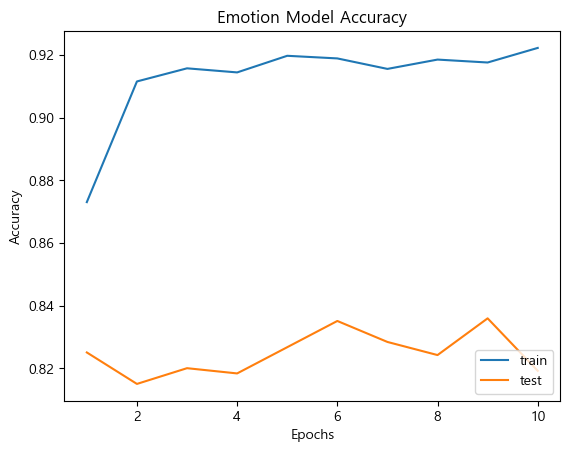

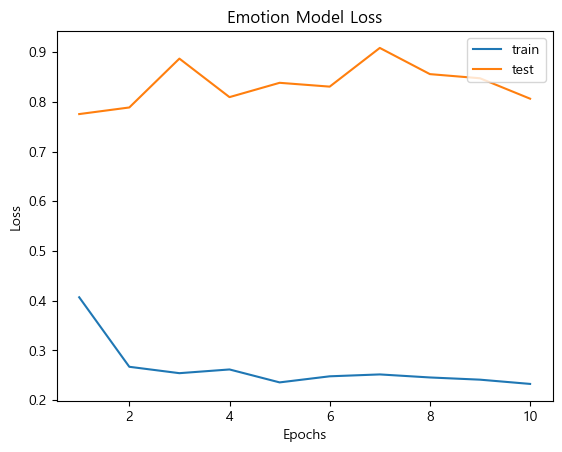

In [50]:
# Plot accuracy and loss graphs for emotion classification
epochs = range(1, len(history_emotion.history['acc']) + 1)
plt.plot(epochs, history_emotion.history['acc'])
plt.plot(epochs, history_emotion.history['val_acc'])
plt.title('Emotion Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

epochs = range(1, len(history_emotion.history['loss']) + 1)
plt.plot(epochs, history_emotion.history['loss'])
plt.plot(epochs, history_emotion.history['val_loss'])
plt.title('Emotion Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
